# Preprocessing CGE data

In [6]:
import boto3
import io
import json
import pandas as pd
import sys
from os.path import expanduser

home = expanduser("~")
sys.path.append(f"{home}/ml-uhi/src/preprocessing")
from preprocessing import change_features_names, get_station_name, feature_engineer_pipeline

In [7]:
# AWS credentials to read files on S3 bucket
f = open('../credentials.json')
credentials = json.load(f)

s3_client = boto3.client(
    's3',
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

s3_resource = boto3.resource(
    's3',
    aws_access_key_id=credentials["Access key ID"],
    aws_secret_access_key=credentials["Secret access key"]
    )

In [8]:
df_full = []
for year in list(range(2009, 2019+1)):  
    prefix=f"raw/{year}/"
    prefix_objs = s3_resource.Bucket("cge").objects.filter(Prefix=prefix)
    keys = [obj.key for obj in prefix_objs]
    for key in keys:
        obj = s3_client.get_object(Bucket="cge", Key=key)
        df = pd.read_csv(io.BytesIO(obj["Body"].read()))
        df_full.append(df)

In [9]:
cge = pd.concat(df_full, ignore_index=True)
cge = cge.drop_duplicates(ignore_index=True)
cge = get_station_name(cge)
cge[['Posto Nome']] = cge[['Posto Nome']].replace('NaN', '1000300')

cge = cge[[
    'Posto',
    'Posto Nome',
    'DATA',
    'PLU(mm)',
    'Vel.VT(m/s)',
    'Dir.VT(o)',
    'Temp(oC)',
    'Umid.Rel.(%)',
    'Pressão(mb)',
    'Rajada.VT(m/s)',
    'Sens. Térmica(°C)'
    ]]

cge = cge[cge['Posto Nome'].isin(['Sé', 'Lapa', 'Pirituba', 'Penha', 'Jabaquara', 'Parelheiros'])]
cge = change_features_names(cge)
cge = cge.dropna(subset=['temperature'])
cge = feature_engineer_pipeline(cge)

/home/ubuntu/ml-uhi/src/preprocessing/preprocessing.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[x_name] = wv * np.cos(wd_rad)
/home/ubuntu/ml-uhi/src/preprocessing/preprocessing.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[y_name] = wv * np.sin(wd_rad)
/home/ubuntu/ml-uhi/src/preprocessing/preprocessing.py:109: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only 

In [10]:
cge.station_name.unique()

array(['Lapa', 'Sé', 'Parelheiros', 'Pirituba', 'Penha', 'Jabaquara'],
      dtype=object)

In [11]:
for i in cge.station_name.unique():
    print(i, cge[cge.station_name == i].timestamp.max())

Lapa 2019-02-18 22:00:00
Sé 2019-02-18 22:00:00
Parelheiros 2019-02-18 22:00:00
Pirituba 2019-02-18 22:00:00
Penha 2019-02-18 22:00:00
Jabaquara 2019-02-18 22:00:00


In [12]:
cge

,station,station_name,timestamp,temperature,precipitation,relative_humidity,pressure,wind_velocity_x,wind_velocity_y,wind_blow_x,wind_blow_y,day_sin,day_cos,year_sin,year_cos
0,1000848,Lapa,2012-09-27 15:00:00,13.997500,0.0,62.604000,948.365000,NaN,NaN,NaN,NaN,-0.707107,-7.071068e-01,-0.998196,-0.060034
1,1000848,Lapa,2012-09-27 16:00:00,14.230833,0.0,63.378167,946.660000,NaN,NaN,NaN,NaN,-0.866025,-5.000000e-01,-0.998239,-0.059318
2,1000848,Lapa,2012-09-27 17:00:00,14.303000,0.0,64.452333,946.225000,NaN,NaN,NaN,NaN,-0.965926,-2.588190e-01,-0.998281,-0.058603
3,1000848,Lapa,2012-09-27 18:00:00,14.212167,0.0,65.090333,946.263333,NaN,NaN,NaN,NaN,-1.000000,-6.383261e-12,-0.998323,-0.057887
4,1000848,Lapa,2012-09-27 19:00:00,13.584333,0.0,68.237833,947.458333,NaN,NaN,NaN,NaN,-0.965926,2.588190e-01,-0.998364,-0.057172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32665,634,Jabaquara,2019-02-18 18:00:00,27.590500,0.0,55.360833,924.640000,NaN,NaN,NaN,NaN,-1.000000,-1.011709e-11,0.745081,0.666974
32666,634,Jabaquara,2019-02-18 19:00:00,26.820000,0.0,64.296000,924.540000,NaN,NaN,NaN,NaN,-0.965926,2.588190e-01,0.745559,0.666439
32667,634,Jabaquara,2019-02-18 20:00:00,24.154500,0.0,78.230167,925.338333,NaN,NaN,NaN,NaN,-0.866025,5.000000e-01,0.746037,0.665905
32668,634,Jabaquara,2019-02-18 21:00:00,22.717500,0.0,80.274667,925.993333,NaN,NaN,NaN,NaN,-0.707107,7.071068e-01,0.746514,0.665370


# Forecasting Lapa station temperature

In [13]:
cge[cge.station_name == "Lapa"]

,station,station_name,timestamp,temperature,precipitation,relative_humidity,pressure,wind_velocity_x,wind_velocity_y,wind_blow_x,wind_blow_y,day_sin,day_cos,year_sin,year_cos
0,1000848,Lapa,2012-09-27 15:00:00,13.997500,0.0,62.604000,948.365000,NaN,NaN,NaN,NaN,-0.707107,-7.071068e-01,-0.998196,-0.060034
1,1000848,Lapa,2012-09-27 16:00:00,14.230833,0.0,63.378167,946.660000,NaN,NaN,NaN,NaN,-0.866025,-5.000000e-01,-0.998239,-0.059318
2,1000848,Lapa,2012-09-27 17:00:00,14.303000,0.0,64.452333,946.225000,NaN,NaN,NaN,NaN,-0.965926,-2.588190e-01,-0.998281,-0.058603
3,1000848,Lapa,2012-09-27 18:00:00,14.212167,0.0,65.090333,946.263333,NaN,NaN,NaN,NaN,-1.000000,-6.383261e-12,-0.998323,-0.057887
4,1000848,Lapa,2012-09-27 19:00:00,13.584333,0.0,68.237833,947.458333,NaN,NaN,NaN,NaN,-0.965926,2.588190e-01,-0.998364,-0.057172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56043,1000848,Lapa,2019-02-18 18:00:00,27.068333,0.0,67.378167,930.448333,0.987694,-1.814244,3.193784,-4.762114,-1.000000,-1.011709e-11,0.745081,0.666974
56044,1000848,Lapa,2019-02-18 19:00:00,26.657000,0.0,69.979500,930.051667,0.917986,-0.961140,2.594402,-4.523592,-0.965926,2.588190e-01,0.745559,0.666439
56045,1000848,Lapa,2019-02-18 20:00:00,26.392000,0.0,71.525833,930.355000,0.097844,-0.196218,1.376222,-3.055869,-0.866025,5.000000e-01,0.746037,0.665905
56046,1000848,Lapa,2019-02-18 21:00:00,25.975667,0.0,72.498333,930.805000,0.079571,-0.134955,-0.145668,-0.977395,-0.707107,7.071068e-01,0.746514,0.665370


In [75]:
def make_lags(df, y):
    for i in range(1,36):
        df[f"{y}_lag_{i+1}"] = df[y].shift(i+1)
    return df


def make_steps(df, y):
    for i in range(6):
        df[f"{y}_step_{i+1}"] = df[y].shift(-i+1)
    return df

X = make_lags(df=cge[cge.station_name == "Lapa"][["temperature"]], y="temperature").dropna().drop("temperature", axis=1)
y = make_steps(df=cge[cge.station_name == "Lapa"][["temperature"]], y="temperature").dropna().drop("temperature", axis=1)

y, X = y.align(X, join="inner", axis=0)

In [76]:
from sklearn.multioutput import RegressorChain
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [77]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

Train RMSE: 1.12
Test RMSE: 1.47


<AxesSubplot: xlabel='timestamp'>

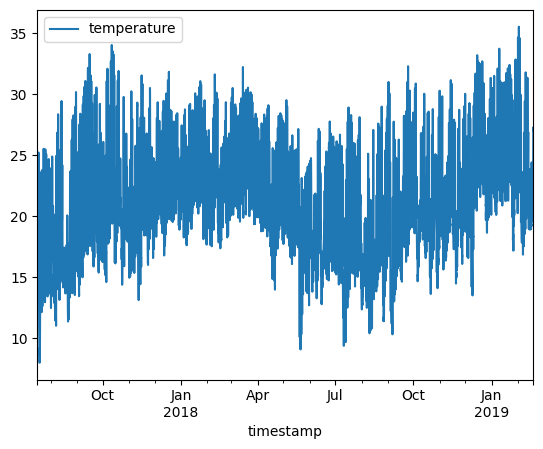

In [78]:
test = lapa[X_test.index[0]:X_test.index[-1]][["timestamp", "temperature"]].set_index("timestamp")
test.plot()

In [79]:
test

,temperature
timestamp,
2017-07-16 09:00:00,15.506333
2017-07-16 10:00:00,15.669333
2017-07-16 11:00:00,17.305833
2017-07-16 12:00:00,18.915500
2017-07-16 13:00:00,20.668167
...,...
2019-02-18 14:00:00,26.064667
2019-02-18 15:00:00,26.781500
2019-02-18 16:00:00,26.897333


In [94]:
ts = pd.date_range(start="2019-02-18 15:00:00", periods=6, freq="H")
ts

DatetimeIndex(['2019-02-18 15:00:00', '2019-02-18 16:00:00',
               '2019-02-18 17:00:00', '2019-02-18 18:00:00',
               '2019-02-18 19:00:00', '2019-02-18 20:00:00'],
              dtype='datetime64[ns]', freq='H')

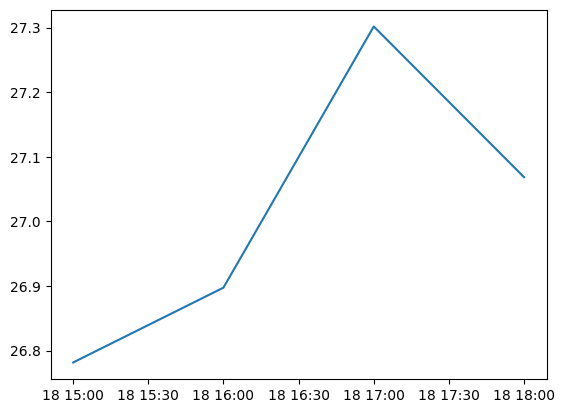

In [95]:
import matplotlib.pyplot as plt 

# train_plot = test[ts:36]
test_plot = test[ts[0]:ts[-1]]

# plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

In [81]:
y_pred["timestamp"] = lapa[y_pred.index[0]:y_pred.index[-1]]["timestamp"]
y_pred

,temperature_step_1,temperature_step_2,temperature_step_3,temperature_step_4,temperature_step_5,temperature_step_6,timestamp
42042,14.585947,14.595813,15.212442,16.580721,18.603573,20.860802,NaT
42043,15.174644,15.533500,16.426548,18.209038,20.080521,21.823582,NaT
42044,16.028305,17.066950,18.498520,20.617842,22.456839,23.693666,NaT
42045,16.036400,18.303709,20.475988,22.359713,23.656212,24.472736,NaT
42046,18.882069,21.194855,22.939779,24.097605,24.892439,25.447861,NaT
...,...,...,...,...,...,...,...
56039,24.792095,25.584742,25.998459,26.296446,25.969898,25.305126,2019-02-18 14:00:00
56040,25.946688,26.656673,26.748320,26.732094,26.082170,24.886124,2019-02-18 15:00:00
56041,26.614733,26.790661,26.565933,26.019005,24.997282,23.678530,2019-02-18 16:00:00
56042,26.915812,26.731834,26.185144,25.195881,24.070410,22.915451,2019-02-18 17:00:00


In [82]:
y_pred

,temperature_step_1,temperature_step_2,temperature_step_3,temperature_step_4,temperature_step_5,temperature_step_6,timestamp
42042,14.585947,14.595813,15.212442,16.580721,18.603573,20.860802,NaT
42043,15.174644,15.533500,16.426548,18.209038,20.080521,21.823582,NaT
42044,16.028305,17.066950,18.498520,20.617842,22.456839,23.693666,NaT
42045,16.036400,18.303709,20.475988,22.359713,23.656212,24.472736,NaT
42046,18.882069,21.194855,22.939779,24.097605,24.892439,25.447861,NaT
...,...,...,...,...,...,...,...
56039,24.792095,25.584742,25.998459,26.296446,25.969898,25.305126,2019-02-18 14:00:00
56040,25.946688,26.656673,26.748320,26.732094,26.082170,24.886124,2019-02-18 15:00:00
56041,26.614733,26.790661,26.565933,26.019005,24.997282,23.678530,2019-02-18 16:00:00
56042,26.915812,26.731834,26.185144,25.195881,24.070410,22.915451,2019-02-18 17:00:00


In [85]:
pd.date_range(start="2019-02-18 15:00:00", periods=6, freq="H")

DatetimeIndex(['2019-02-18 15:00:00', '2019-02-18 16:00:00',
               '2019-02-18 17:00:00', '2019-02-18 18:00:00',
               '2019-02-18 19:00:00', '2019-02-18 20:00:00'],
              dtype='datetime64[ns]', freq='H')

In [92]:
pred = y_pred.loc[[56039]].drop("timestamp", axis=1).T
pred.index = pd.date_range(start="2019-02-18 15:00:00", periods=6, freq="H")
pred.columns = ["temperature"]
pred

,temperature
2019-02-18 15:00:00,24.792095
2019-02-18 16:00:00,25.584742
2019-02-18 17:00:00,25.998459
2019-02-18 18:00:00,26.296446
2019-02-18 19:00:00,25.969898
2019-02-18 20:00:00,25.305126


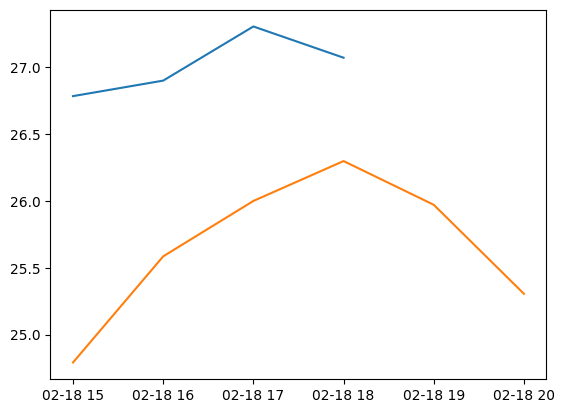

In [96]:
import matplotlib.pyplot as plt 

# train_plot = test[ts:36]
test_plot = test[ts[0]:ts[-1]]

# plt.plot(train_plot)
plt.plot(test_plot)
plt.plot(pred)
plt.show()